Project root ditemukan: c:\Users\jorda\Documents\belajar\code\python\btc-quant-prob
Mencari data di: c:\Users\jorda\Documents\belajar\code\python\btc-quant-prob\raw_data\bitcoin_historical_data.csv
File ditemukan: False
Loading existing data from /raw_data/bitcoin_historical_data.csv...
Existing data ends on: 1970-01-01. Downloading updates from 1970-01-02...


c:\Users\jorda\Documents\belajar\code\python\btc-quant-prob\data\ingest.py:29: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_old = pd.read_csv(raw_path_obj)
c:\Users\jorda\Documents\belajar\code\python\btc-quant-prob\data\ingest.py:82: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_new = yf.download(


Downloaded 4074 new rows up to 2025-11-11.
Data successfully updated and saved to \raw_data\bitcoin_historical_data.csv.
Data ingestion and daily resampling complete.
Data shape: (20404, 71)
Date range: 1970-01-01 to 2025-11-11


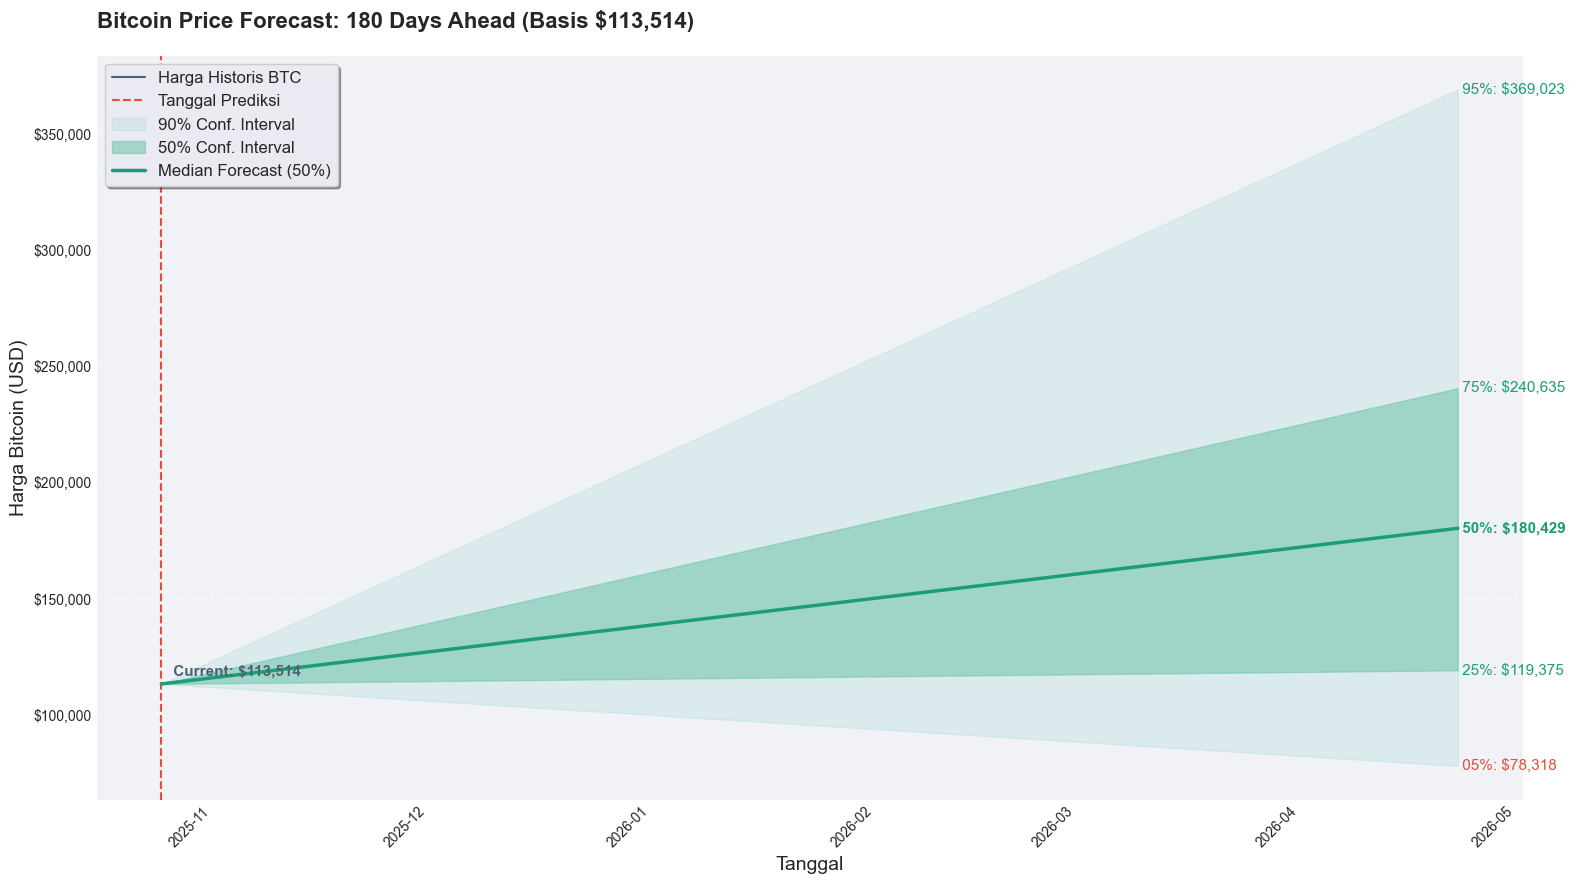

In [1]:
# --- PENTING: BARIS PERBAIKAN UNTUK JALUR FILE ---
import sys
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# 1. Tentukan Root Proyek secara eksplisit
try:
    current_dir = Path.cwd()
    project_root = current_dir
    while not (project_root / 'data').is_dir() and project_root != project_root.parent:
        project_root = project_root.parent
        
    if project_root not in sys.path:
        sys.path.insert(0, str(project_root))
        
    print(f"Project root ditemukan: {project_root}")
    
except Exception as e:
    print(f"Peringatan: Gagal menemukan project root otomatis. Error: {e}")
    # Jika gagal, asumsikan path manual (sesuaikan jika perlu)
    project_root = Path('c:/Users/jorda/Documents/belajar/code/python/btc-quant-prob')
    sys.path.insert(0, str(project_root))
    
# 2. Import Fungsi (Sekarang sudah aman karena path sistem sudah diatur)
# Pastikan file data/ingest.py sudah berisi fungsi load_and_clean_data
from data.ingest import load_and_clean_data 
# -----------------------------------------------------------------------------

# Periksa apakah file data asli benar-benar ada (debugging visual)
data_path = project_root / 'raw_data' / 'bitcoin_historical_data.csv'
print(f"Mencari data di: {data_path}")
print(f"File ditemukan: {data_path.exists()}")

# --- 1. Definisi Data Prediksi ---
log_returns = {
    0.05: -0.371138,
    0.25: 0.050351,
    0.50: 0.463416,
    0.75: 0.751358,
    0.95: 1.178936
}
P_now = 113513.50
# Gunakan datetime.now() untuk update otomatis, atau tetap 2025-10-25 untuk konsistensi
date_now = pd.to_datetime('2025-10-25') 
horizon = 180
date_end = date_now + timedelta(days=horizon)

# --- 2. Proyeksi Harga Akhir ---
P_end = {q: P_now * np.exp(r) for q, r in log_returns.items()}

# --- 3. Buat Garis Proyeksi (Linier/Sederhana) ---
projection_days = pd.date_range(start=date_now, end=date_end, periods=horizon + 1)
projection_df = pd.DataFrame(index=projection_days)

for q in log_returns.keys():
    price_path = np.linspace(P_now, P_end[q], horizon + 1)
    projection_df[f'q_{q:.2f}'] = price_path

# --- 4. Muat Data Historis Asli ---
# Gunakan project_root untuk membuat path absolut ke config.json
config_path = project_root / 'train' / 'config.json'

with open(config_path, 'r') as f:
    config = json.load(f)

# Panggil fungsi dari data/ingest.py
df_hist_full = load_and_clean_data(config['data']['raw_path'])

# !!! PERBAIKAN KRITIS UNTUK TYPERROR MATPLOTLIB !!!
# Memastikan kolom 'Close' adalah numerik dan menghapus baris NaN
df_hist_full['Close'] = pd.to_numeric(df_hist_full['Close'], errors='coerce')
df_hist_full.dropna(subset=['Close'], inplace=True)
# !!! AKHIR PERBAIKAN KRITIS !!!

df_hist = df_hist_full['Close']

# Pastikan harga terakhir di historis sama dengan P_now
df_hist_before_now = df_hist[df_hist.index < date_now]
df_hist_context = df_hist_before_now.reindex(df_hist_before_now.index.union([date_now]))
df_hist_context.loc[date_now] = P_now
df_hist = df_hist_context

history_start_date = date_now - timedelta(days=365*2)
df_hist_context = df_hist[df_hist.index >= history_start_date]

# --- 5. Visualisasi Profesional ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

fig, ax = plt.subplots(figsize=(16, 9))

# a. Plot Harga Historis
ax.plot(df_hist_context.index, df_hist_context.values, label='Harga Historis BTC', color='#4F6272', linewidth=1.5)
ax.axvline(date_now, color='#E74C3C', linestyle='--', linewidth=1.5, label='Tanggal Prediksi')

# b. Plot Pita Keyakinan (Fan Chart)
ax.fill_between(
    projection_df.index, 
    projection_df['q_0.05'], 
    projection_df['q_0.95'], 
    color='#A8DADC', 
    alpha=0.3, 
    label='90% Conf. Interval'
)

ax.fill_between(
    projection_df.index, 
    projection_df['q_0.25'], 
    projection_df['q_0.75'], 
    color='#66C2A4', 
    alpha=0.5, 
    label='50% Conf. Interval'
)

# d. Plot Garis Median (q0.50)
ax.plot(
    projection_df.index, 
    projection_df['q_0.50'], 
    color='#1B9E77', 
    linestyle='-', 
    linewidth=2.5, 
    label='Median Forecast (50%)'
)

# --- Anotasi Penting ---
ax.text(date_now + timedelta(days=1), P_now * 1.02, f' Current: ${P_now:,.0f}', 
        verticalalignment='bottom', horizontalalignment='left', 
        color='#4F6272', fontsize=11, fontweight='bold')

# Prediksi Harga Akhir
ax.text(date_end, P_end[0.95], f' 95%: ${P_end[0.95]:,.0f}', color='#1B9E77', fontsize=11, verticalalignment='center')
ax.text(date_end, P_end[0.75], f' 75%: ${P_end[0.75]:,.0f}', color='#1B9E77', fontsize=11, verticalalignment='center')
ax.text(date_end, P_end[0.50], f' 50%: ${P_end[0.50]:,.0f}', color='#1B9E77', fontsize=11, verticalalignment='center', fontweight='bold')
ax.text(date_end, P_end[0.25], f' 25%: ${P_end[0.25]:,.0f}', color='#1B9E77', fontsize=11, verticalalignment='center')
ax.text(date_end, P_end[0.05], f' 05%: ${P_end[0.05]:,.0f}', color='#E74C3C', fontsize=11, verticalalignment='center')


# Label dan Judul
ax.set_title(f'Bitcoin Price Forecast: {horizon} Days Ahead (Basis ${P_now:,.0f})', loc='left', pad=20, fontweight='bold')
ax.set_xlabel('Tanggal')
ax.set_ylabel('Harga Bitcoin (USD)')
ax.legend(loc='upper left', frameon=True, shadow=True, fancybox=True)
ax.grid(True, linestyle=':', alpha=0.6)
ax.set_facecolor('#F0F2F5')

# Format y-axis ke dalam format dolar
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, p: f'${x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()